# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "dateAdded" : "Date"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            new_row = { 
                'CVE': cve, 
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
        
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3']);
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan);       

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Date"]]

## CISA KEV Score Scatter Plot

Matplotlib is building the font cache; this may take a moment.


/opt/hostedtoolcache/Python/3.10.18/x64/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1351: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


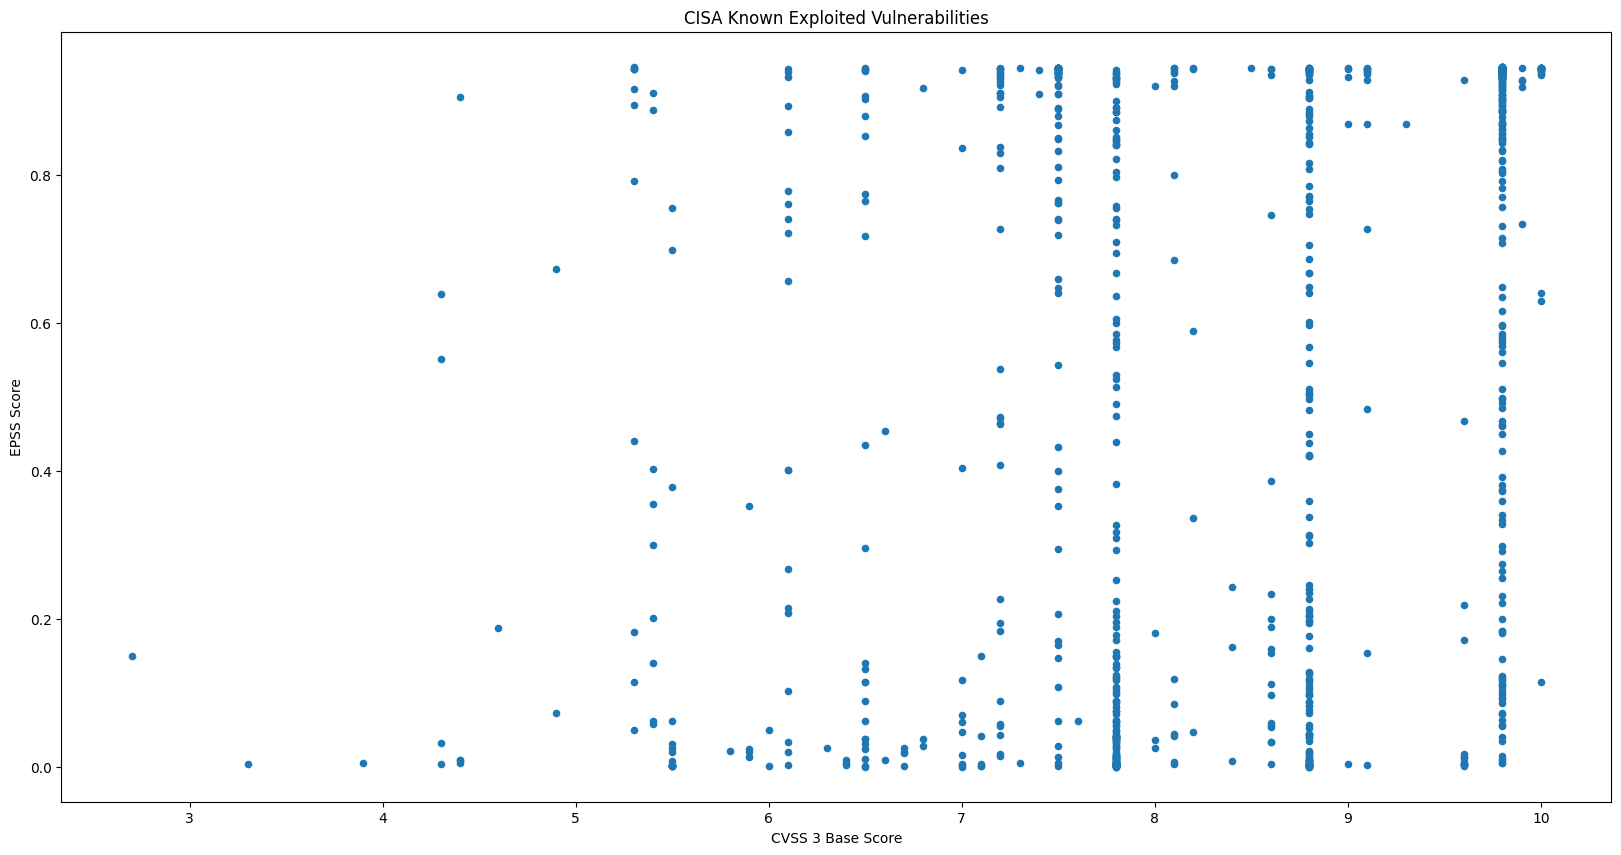

In [6]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                     y='EPSS',
                     colormap='jet',
                     figsize=(20, 10),
                     title='CISA Known Exploited Vulnerabilities');
ax.set_xlabel("CVSS 3 Base Score");
ax.set_ylabel("EPSS Score");
ax.figure.savefig('epss_kev_nvd.png');

## Export to CSV

In [7]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Date
0,CVE-2025-6543,NaN,0.00057,0.17867,Citrix NetScaler ADC and Gateway contain a buf...,2025-06-30
1,CVE-2019-6693,6.5,0.76493,0.98872,Fortinet FortiOS contains a use of hard-coded ...,2025-06-25
2,CVE-2024-0769,9.8,0.75565,0.98825,D-Link DIR-859 routers contain a path traversa...,2025-06-25
3,CVE-2024-54085,9.8,0.09467,0.92419,AMI MegaRAC SPx contains an authentication byp...,2025-06-25
4,CVE-2023-0386,7.8,0.57628,0.98021,Linux Kernel contains an improper ownership ma...,2025-06-17
5,CVE-2023-33538,8.8,0.90630,0.99583,"TP-Link TL-WR940N V2/V4, TL-WR841N V8/V10, and...",2025-06-16
6,CVE-2025-43200,NaN,0.00759,0.72279,"Apple iOS, iPadOS, macOS, watchOS, and visionO...",2025-06-16
7,CVE-2025-33053,NaN,0.30219,0.96437,Microsoft Windows contains an external control...,2025-06-10
8,CVE-2025-24016,NaN,0.92278,0.99703,Wazuh contains a deserialization of untrusted ...,2025-06-10
9,CVE-2024-42009,9.3,0.86797,0.99374,RoundCube Webmail contains a cross-site script...,2025-06-09
